In [1]:
import tensorflow as tf
import keras
import os
import cv2
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.metrics import structural_similarity as ssim
from keras.models import load_model
from scipy.stats import gaussian_kde
from bhatta_dist import bhatta_dist

In [11]:
def loss_ssim(y_true, y_pred):
    # Calculer le data_range
    data_range = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=data_range))

In [4]:
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        # Ajuste les dimensions
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Deuxième convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(shape=(150, 150, 1), input_latent=64):
    input_img = tf.keras.Input(shape=shape)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 250, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 250, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)

    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150,150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=[x_recon])
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=10000,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss=loss_ssim, metrics=['mae'])
    #model.summary()
    return model

In [2]:
# Fairface
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder_fairface(input_latent=512):
    input_img = tf.keras.Input(shape=(150, 150, 1))
    x = tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 1024, 3, 2)
    x = residual_block(x, 2048, 3, 2)
    x = residual_block(x, input_latent, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(x)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, input_latent, 3, 1)
    x_recon = residual_block_recon(x_recon, 2048, 3, 2)
    x_recon = residual_block_recon(x_recon, 1024, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)
    
    x_recon = residual_block_recon(x_recon, 16, 3, 2)
    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150, 150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=42237,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255)
trainset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Caucasiens'],
    target_size=(150, 150), 
    batch_size=64, 
    class_mode='input',
    color_mode='grayscale')
testset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Caucasiens'],
    target_size=(150, 150), 
    batch_size=64, 
    class_mode='input',
    color_mode='grayscale')
trainset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Asiatiques'],
    target_size=(150, 150),
    batch_size=64,
    class_mode='input',
    color_mode='grayscale')
testset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Asiatiques'],
    target_size=(150, 150),
    batch_size=64,
    class_mode='input',
    color_mode='grayscale')
trainset_mixed = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/',
    classes=['Mixtes'],
    target_size=(150, 150), 
    batch_size=64, 
    class_mode='input',
    color_mode='grayscale')

Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 112 images belonging to 1 classes.


### Entrainement réseau & Récupération de la couche latente

In [7]:
for latent in [32, 64, 128]:
    model = create_resnet_autoencoder(input_latent=latent)
    chekpoint_path = f'Modeles/STIM/Autoencoder_white_{latent}.hdf5'
    checkpoint_callback = ModelCheckpoint(
        filepath=chekpoint_path,
        save_weights_only=False,
        save_frequency='epoch',
        save_best_only=True)    
    model.fit(x=trainset_white, epochs=15000, validation_data=trainset_white, verbose=0)

for latent in [32, 64, 128]:
    model = create_resnet_autoencoder(input_latent=latent)
    chekpoint_path = f'Modeles/STIM/Autoencoder_asian_{latent}.hdf5'
    checkpoint_callback = ModelCheckpoint(
        filepath=chekpoint_path,
        save_weights_only=False,
        save_frequency='epoch',
        save_best_only=True)    
    model.fit(x=trainset_asian, epochs=15000, validation_data=trainset_asian, verbose=0)

In [3]:
# Function to generate unique random vectors
def generate_unique_vectors(num_vectors, vector_length, vectors):
    vectors_liste = []
    while len(vectors_liste) < num_vectors:
        vector = tuple(np.random.randint(0, 2, vector_length))
        if vector not in vectors:
            vectors.add(vector)
            vectors_liste.append(vector)
    return vectors_liste, vectors

# Function to convert generator to numpy arrays
def generator_to_array(generator, class_vectors):
    samples = []
    vectors = []
    data_filenames = generator.filenames
    total_images = len(data_filenames)

    for i in range(len(generator)):
        batch = generator.next()
        batch_size = len(batch[0])

        for j in range(batch_size):
            index = i * generator.batch_size + j
            if index >= total_images:
                break  # Prevent going out of bounds

            samples.append(batch[0][j])
            class_name = data_filenames[index].split(os.path.sep)[0]
            vectors.append(class_vectors[class_name])
            
    return np.array(samples), np.array(vectors), data_filenames

def preprocess(train_generator, val_generator, n, total_vectors):
    class_indices = train_generator.class_indices
    unique_vectors, total_vectors = generate_unique_vectors(n, 56, total_vectors)
    class_vectors =  {class_name: vector for class_name, vector in zip(class_indices, unique_vectors)}
    samples_train, vectors_train, _ = generator_to_array(train_generator, class_vectors)
    samples_val, vectors_val, _ = generator_to_array(val_generator, class_vectors)
    return samples_train, vectors_train, samples_val, vectors_val, total_vectors

# Data generator with rescaling and validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.02, dtype='float16')

def load_data(datagen, target_size = (150, 150), batch_size = 64, class_mode = 'input', shuffle = False, color_mode = 'grayscale'):
    ethnies = {'caucasians': [], 'afro_americans': [], 'asians': []}
    total_vectors = set()
    check = True
    for ethnie in ethnies.keys():
        trainset = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size = target_size, batch_size = batch_size, class_mode = class_mode, shuffle = shuffle, color_mode = color_mode)
        testset = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size = target_size, batch_size = batch_size, class_mode = class_mode, shuffle = shuffle, color_mode = color_mode, subset = 'validation')
        samples_train, vectors_train, samples_val, vectors_val, total_vectors = preprocess(trainset, testset, 56, total_vectors)
        if trainset.n != samples_train.shape[0] or testset.n != samples_val.shape[0]:
            check = False
        ethnies[ethnie] = [trainset, testset, samples_train, vectors_train, samples_val, vectors_val]
    print(check)
    return ethnies

ethnies = load_data(datagen)

Found 4184 images belonging to 21 classes.
Found 75 images belonging to 21 classes.
Found 4443 images belonging to 22 classes.
Found 80 images belonging to 22 classes.
Found 4368 images belonging to 21 classes.
Found 75 images belonging to 21 classes.
True


In [4]:
model = create_resnet_autoencoder_fairface(input_latent=256)

In [5]:
x_train = ethnies['caucasians'][0]
x_val   = ethnies['caucasians'][1]

In [7]:
model.fit(x=x_train, epochs = 20, validation_data=x_val, verbose=2)

Epoch 1/20
66/66 - 49s - loss: 0.0997 - mae: 0.2625 - val_loss: 0.0797 - val_mae: 0.2459 - 49s/epoch - 748ms/step
Epoch 2/20
66/66 - 31s - loss: 0.0874 - mae: 0.2525 - val_loss: 0.0775 - val_mae: 0.2432 - 31s/epoch - 477ms/step
Epoch 3/20
66/66 - 32s - loss: 0.0845 - mae: 0.2499 - val_loss: 0.0771 - val_mae: 0.2425 - 32s/epoch - 479ms/step
Epoch 4/20
66/66 - 32s - loss: 0.0831 - mae: 0.2483 - val_loss: 0.0769 - val_mae: 0.2421 - 32s/epoch - 479ms/step
Epoch 5/20
66/66 - 32s - loss: 0.0821 - mae: 0.2471 - val_loss: 0.0768 - val_mae: 0.2419 - 32s/epoch - 480ms/step
Epoch 6/20
66/66 - 32s - loss: 0.0811 - mae: 0.2456 - val_loss: 0.0766 - val_mae: 0.2415 - 32s/epoch - 480ms/step
Epoch 7/20
66/66 - 32s - loss: 0.0798 - mae: 0.2434 - val_loss: 0.0762 - val_mae: 0.2406 - 32s/epoch - 480ms/step
Epoch 8/20
66/66 - 32s - loss: 0.0778 - mae: 0.2398 - val_loss: 0.0750 - val_mae: 0.2385 - 32s/epoch - 479ms/step
Epoch 9/20
66/66 - 32s - loss: 0.0748 - mae: 0.2343 - val_loss: 0.0719 - val_mae: 0.2330

In [18]:
images = ethnies['caucasians'][2]

In [23]:
np.random.shuffle(images)

In [24]:
test = images[0:5]

1/1 [==============================] - 0s 26ms/step


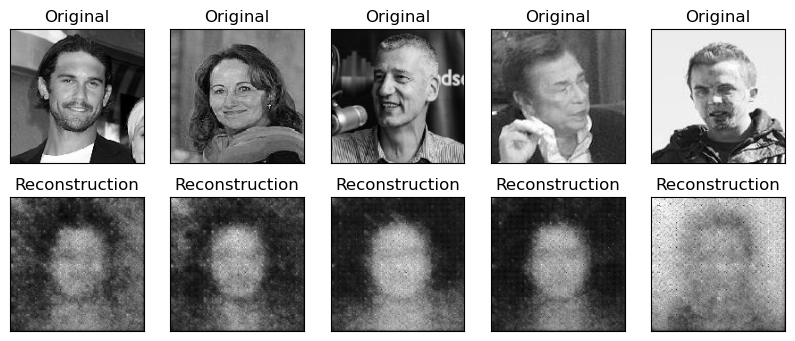

In [25]:
prediction = model.predict(test)

num_images = 5
plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Afficher l'image originale
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(cv2.resize(test[i],(150, 150), interpolation=cv2.INTER_LINEAR), cmap='gray')
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(cv2.resize(prediction[i], (150, 150), interpolation=cv2.INTER_LINEAR), cmap='gray')
    plt.title("Reconstruction")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [38]:
# Pour la MSE DNN : 
# 1 °) On crée un modèle qui sache discriminer entre les carctéristiques propres aux deux ethnies
# (donc, par exemple, un AE ayant été entraîné sur datatrain_mixed qui comporte les deux ethnies à part égale lors de l'entraînement)
AE_non_biased = create_resnet_autoencoder()
chekpoint_path = f'Modeles/STIM/Autoencoder_mixte_64.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True)
AE_non_biased.fit(x=trainset_mixed, epochs = 10000, validation_data=trainset_mixed, callbacks=[checkpoint_callback])

Epoch 1/10000
2/2 [==============================] - 9s 3s/step - loss: 0.9654 - mae: 0.4000 - val_loss: 0.8198 - val_mae: 0.4038
Epoch 2/10000
2/2 [==============================] - 1s 492ms/step - loss: 0.9649 - mae: 0.4000 - val_loss: 0.8196 - val_mae: 0.4045
Epoch 3/10000
2/2 [==============================] - 1s 502ms/step - loss: 0.9610 - mae: 0.3993 - val_loss: 0.8195 - val_mae: 0.4052
Epoch 4/10000
2/2 [==============================] - 1s 473ms/step - loss: 0.9559 - mae: 0.3981 - val_loss: 0.8194 - val_mae: 0.4058
Epoch 5/10000
2/2 [==============================] - 1s 482ms/step - loss: 0.9497 - mae: 0.3976 - val_loss: 0.8192 - val_mae: 0.4064
Epoch 6/10000
2/2 [==============================] - 1s 473ms/step - loss: 0.9433 - mae: 0.3972 - val_loss: 0.8191 - val_mae: 0.4070
Epoch 7/10000
2/2 [==============================] - 1s 486ms/step - loss: 0.9350 - mae: 0.3967 - val_loss: 0.8190 - val_mae: 0.4076
Epoch 8/10000
2/2 [==============================] - 1s 473ms/step - los

In [39]:
test_asian = generator_to_array(testset_asian).reshape(6, 150, 150)
test_asian_predict = AE_non_biased.predict(testset_asian).reshape(6, 150, 150)
test_white = generator_to_array(testset_white).reshape(6, 150, 150)
test_white_predict = AE_non_biased.predict(testset_white).reshape(6, 150, 150)

1/1 [==============================] - 0s 37ms/step


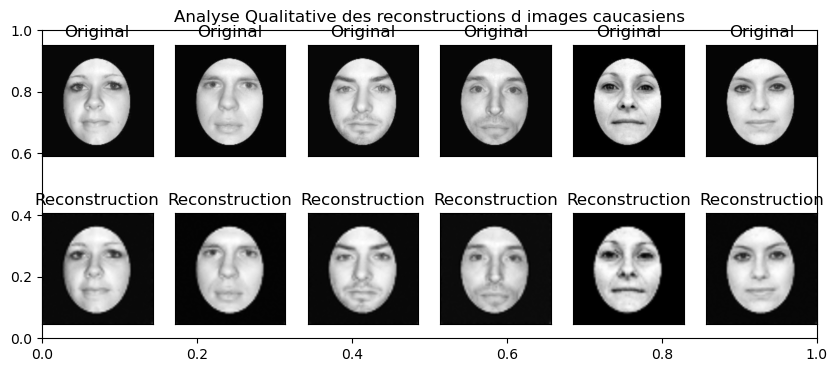

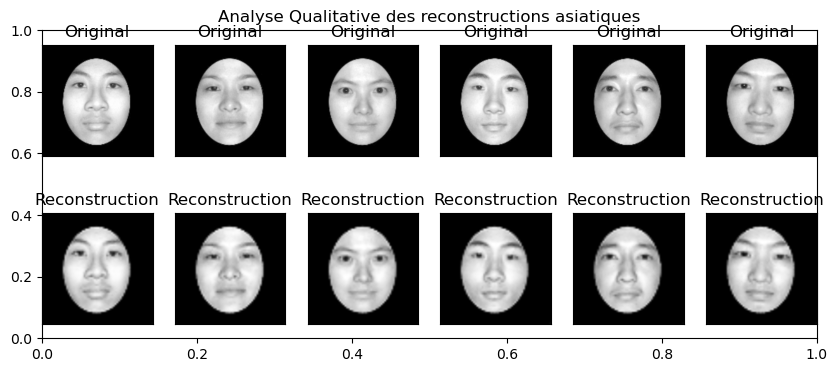

In [40]:
comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, "mixte")

In [202]:
for i in range(6):
    print(ssim(test_asian[i], test_asian_predict[i], data_range=test_asian.max() - test_asian.min(), multichannel=False))

0.5424816434080191
0.543063719604412
0.5669125037875441
0.5486365883008406
0.5616318054783193
0.5690308131497077


In [203]:
for i in range(6):
    print(mse(test_asian[i], test_asian_predict[i]).numpy())

0.1948052
0.19607255
0.16276899
0.20308958
0.14222658
0.1468486


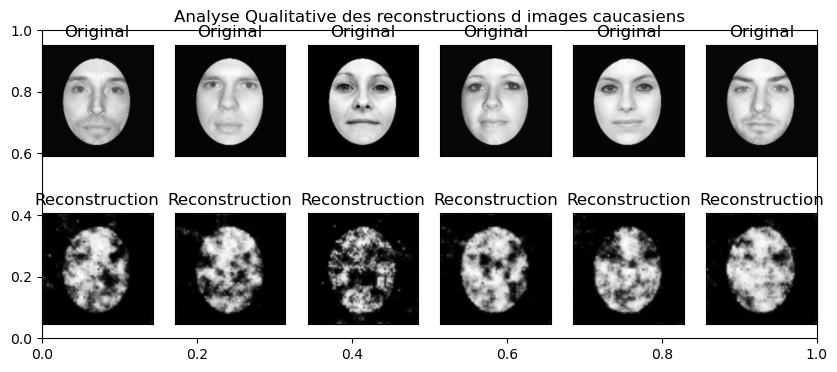

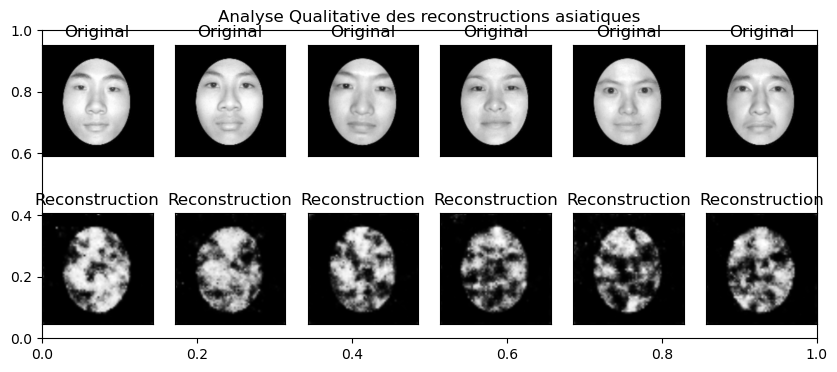

In [198]:
comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, "asian")

2/2 [==============================] - 0s 40ms/step


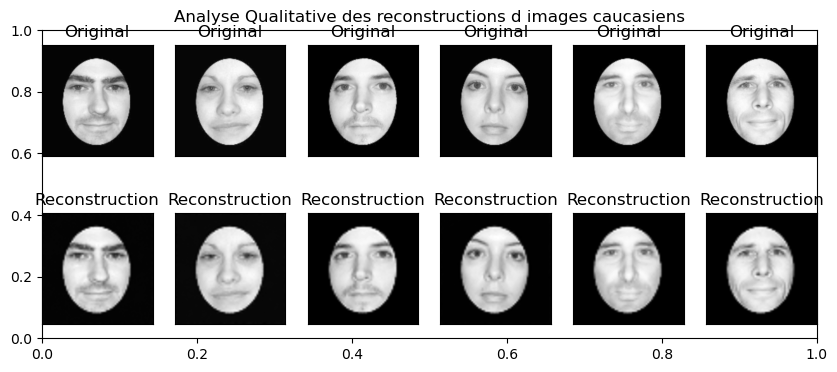

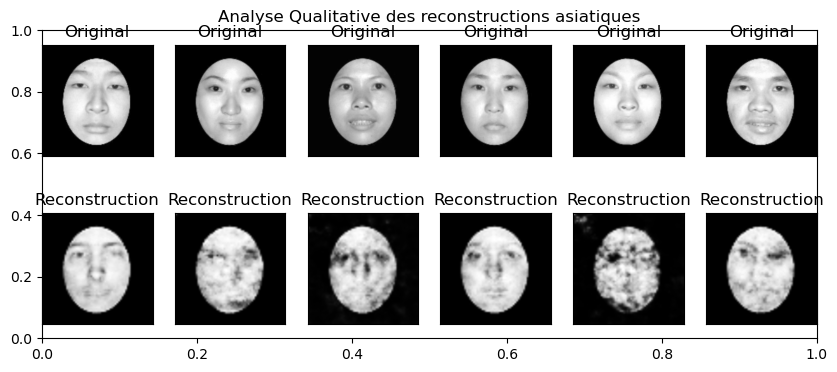

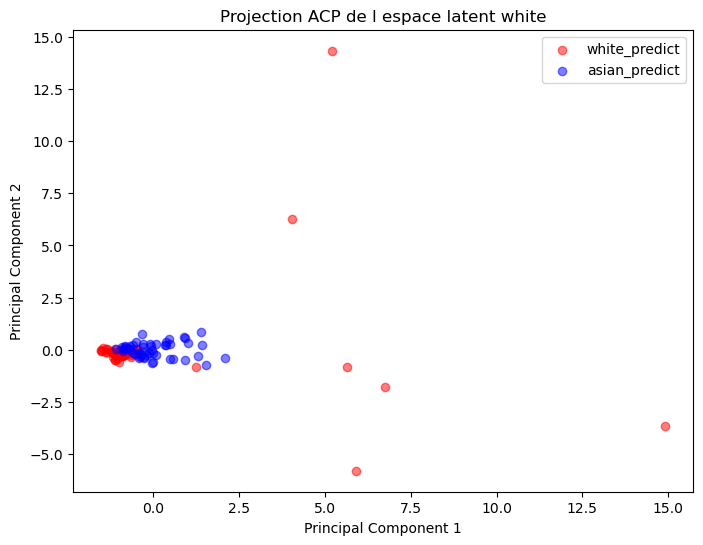

Moyenne des similarités cosinus pour les individus caucasiens : 0.9720786476135254
Moyenne des similarités cosinus pour les individus asiatiques : 0.9339859414100647
Moyenne des dispersions des espaces latents pour les individus caucasiens : 29.52684783935547
Moyenne des dispersions des espaces latents pour les individus asiatiques : 1.0633281469345093
2/2 [==============================] - 0s 70ms/step


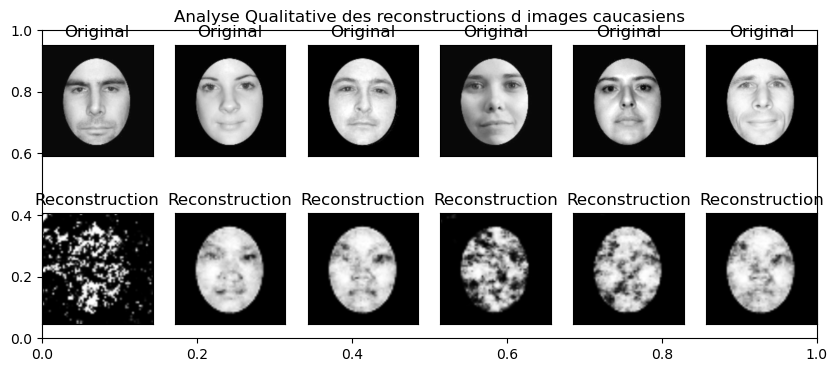

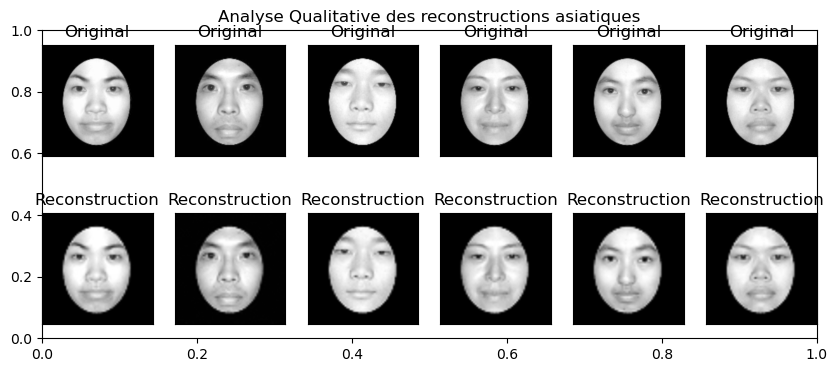

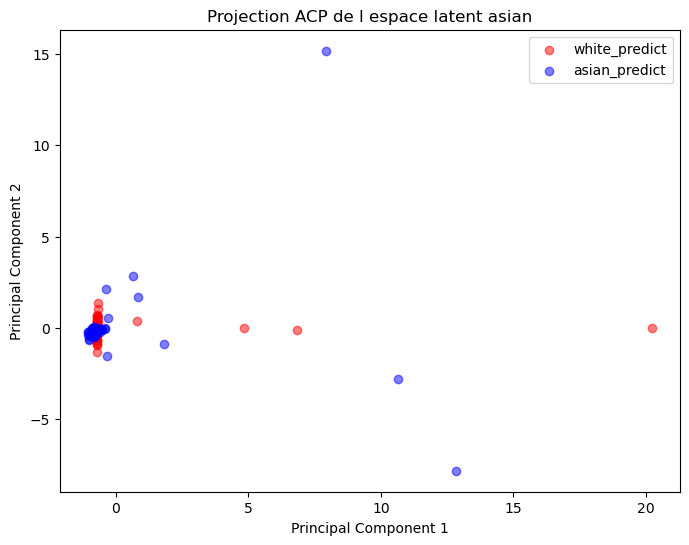

Moyenne des similarités cosinus pour les individus caucasiens : 0.9306182539463044
Moyenne des similarités cosinus pour les individus asiatiques : 0.9862485182285309
Moyenne des dispersions des espaces latents pour les individus caucasiens : 10.893451690673828
Moyenne des dispersions des espaces latents pour les individus asiatiques : 28.516258239746094


In [150]:
for  ethnie in ["white", "asian"]:
    for latent in [32]:
        model = load_model(f'Modeles/STIM/Autoencoder_{ethnie}_{latent}.hdf5', custom_objects={'loss_ssim': loss_ssim})
        get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)

        latent_asian = get_latent.predict(trainset_asian)
        latent_white = get_latent.predict(trainset_white)

        asian_predict = model.predict(trainset_asian).reshape(50,150,150)
        white_predict = model.predict(trainset_white).reshape(50,150,150)
        asian = generator_to_array(trainset_asian).reshape(50,150,150)
        white = generator_to_array(trainset_white).reshape(50,150,150)

        asian_predict_flatten = asian_predict.reshape(50, -1)
        white_predict_flatten = white_predict.reshape(50, -1)
        asian_flatten = asian.reshape(50, -1)
        white_flatten = white.reshape(50, -1)

        test_asian = generator_to_array(trainset_asian)
        test_asian_predict = model.predict(test_asian)
        test_white = generator_to_array(trainset_white)
        test_white_predict = model.predict(test_white)

        comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, ethnie)
        latent_pca = pca(latent_asian, latent_white, ethnie)
        cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten)
        comparaison_dispersion(latent_asian, latent_white)

In [7]:
get_features_map_1 = keras.Model(inputs=model.input, outputs=model.get_layer('conv2d_11').output)
get_features_map_3 = keras.Model(inputs=model.input, outputs=model.get_layer('conv2d_13').output)
get_features_map_2 = keras.Model(inputs=model.input, outputs=model.get_layer('conv2d_14').output)

In [24]:
get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)

In [146]:
model = load_model(f'Modeles/STIM/Autoencoder_white_128.hdf5', custom_objects={'loss_ssim': loss_ssim})

In [148]:
test_asian = generator_to_array(testset_asian)
test_asian_predict = model.predict(test_asian, verbose = 0)
test_white = generator_to_array(testset_white)
test_white_predict = model.predict(test_white, verbose = 0)

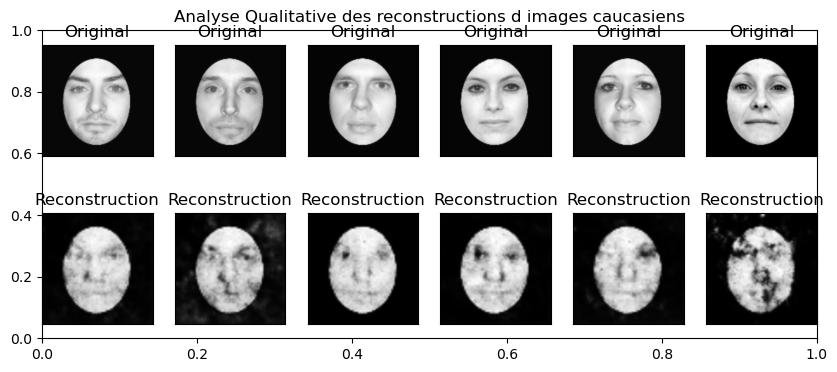

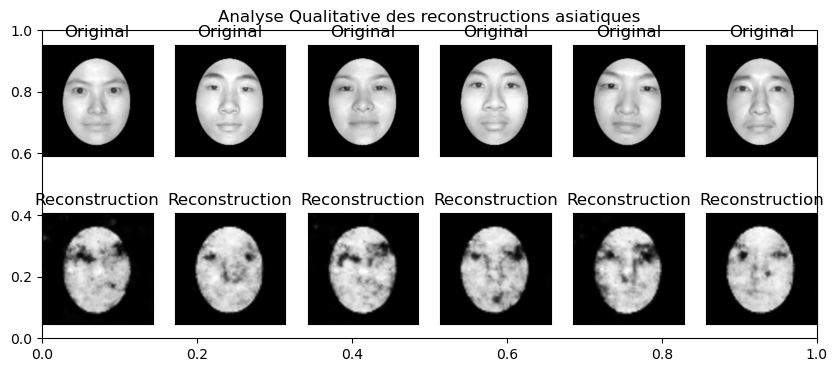

In [149]:
comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, "white")

In [7]:
def mean_bhatta(latent_asian, latent_white):
    res = 0
    for i in range(len(latent_asian)):
        res += bhatta_coeff(latent_asian[i], latent_white[i])
        return res/len(latent_asian)

In [36]:
asian = generator_to_array(trainset_asian).reshape(50,-1)
white = generator_to_array(trainset_white).reshape(50,-1)

In [29]:
white_predict.shape

(50, 150, 150, 1)

In [243]:
def mean_bhatta_coeff(p, q):
    bhatta = 0
    if p.ndim == 1:
        for i in range(p.shape[0]):
            bhatta += np.sqrt((p[i] * q[i]))
        return bhatta
    else:
        for i in range(p.shape[0]):
            for j in range(p.shape[1]):
                bhatta += np.sqrt((p[i, j] * q[i, j]))
    return bhatta/p.shape[0]

In [254]:
for  ethnie in ["white", "asian"]:
    for latent in [32, 64, 128]:
        model = load_model(f'Modeles/STIM/Autoencoder_{ethnie}_{latent}.hdf5', custom_objects={'loss_ssim': loss_ssim})
        get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)
        latent_asian = get_latent.predict(trainset_asian, verbose=0)
        latent_white = get_latent.predict(trainset_white, verbose=0)
        print(f"bhatta_coeff pour {ethnie}_{latent} =  {mean_bhatta_coeff(tf.nn.softmax(latent_asian, axis=1).numpy(), tf.nn.softmax(latent_white, axis=1).numpy())}")

bhatta_coeff pour white_32 =  0.9077655197225977
bhatta_coeff pour white_64 =  0.9005568474705796
bhatta_coeff pour white_128 =  0.7786656781868078
bhatta_coeff pour asian_32 =  0.8591775951054569
bhatta_coeff pour asian_64 =  0.7950492254786866
bhatta_coeff pour asian_128 =  0.7046908647377922


In [77]:
bhatta = 0
for i in range(50):
    bhatta += np.sqrt(np.dot(latent_asian_distrib[0], latent_white_distrib[0]))

In [250]:
distrib = tf.nn.softmax(latent_asian, axis=1).numpy()

In [253]:
distrib[4].sum()

0.99999994

In [247]:
distrib.shape

(50, 32)

In [127]:
mean_bhatta_coeff(latent_asian_distrib, latent_white_distrib)

0.7090639620604026